# METAR Data Analysis Project

METAR is the acronym for Meteorological Aerodrome Report. It is internationally recognized shorthand for weather data used by the aviation community.

Different abbreviations and codes from US Government National Weather Service: [source](https://www.weather.gov/media/wrh/mesowest/metar_decode_key.pdf)

### The Problem:

A Flight school is looking to expand to new locations. You're given METAR data to identify the 10 best and 10 worst locations based on the following criteria:

* Visibility of 10 statute miles or greater 

* Cloud ceiling of 3,000 ft above ground or higher

* Winds less than 15 kts

----

[Airport Data Link](https://data.humdata.org/dataset/ourairports-usa?)

[Kaggle Airport Data](https://www.kaggle.com/datasets/aravindram11/list-of-us-airports)

[US Cities Population](https://catalog.data.gov/dataset/500-cities-city-level-data-gis-friendly-format-2019-release)

### Imports and Reading in Data

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import warnings

# Data File Paths
# metar = '../data/metar_export.txt'
# us_geojson = '../data/gz_2010_us_040_00_500k.json'
# airports = '../data/airports.csv'
# population = './data.500_Cities__City-level_Data__GIS_Friendly_Format___2019_release.csv'

col_names = ['date', 'id', 'obsv_time', 'automated', 'wind_speed', 'visibility', 'cloud_cover', \
            'temp_dewpt', 'altimeter', 'altimeter_remarks', 'ao2']

df = pd.read_csv('../data/metar_export.txt', delimiter=' ', header = None, names = col_names)
airports = pd.read_csv('../data/airports.csv')

print(df.head())
print('='*40)
df.info()

         date              id obsv_time automated wind_speed visibility  \
0  2015-03-25  21:15:00\tKCXP   252115Z      AUTO    08005KT       10SM   
1  2015-03-25  21:13:00\tKWRB   252113Z      AUTO    06005KT       10SM   
2  2015-03-25  21:12:00\tKTUL   252112Z   14006KT       10SM         TS   
3  2015-03-25  21:11:00\tKDRT   252111Z      AUTO    13007KT       10SM   
4  2015-03-25  21:10:00\tKBRL   252110Z      AUTO    33009KT        8SM   

  cloud_cover temp_dewpt altimeter altimeter_remarks    ao2  
0         CLR     17/M01     A3033               RMK    AO2  
1      BKN014     OVC024     20/17             A3009    RMK  
2      BKN035     BKN120    BKN250             24/16  A2975  
3      SCT023      22/17     A2986               RMK    AO2  
4      SCT016      07/03     A3006               RMK    AO2  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731241 entries, 0 to 7731240
Data columns (total 11 columns):
 #   Column             Dtype 
---  ------             ----- 
 0

Need to convert date, windspeed, and visibility to numeric data types.

---

In [71]:
# Checking population Data

us_pop = pd.read_csv('../data/500_Cities__City-level_Data__GIS_Friendly_Format___2019_release.csv')

print(us_pop.head())
print('='*20)
us_pop.info()

  StateAbbr   PlaceName  PlaceFIPS  Population2010  ACCESS2_CrudePrev  \
0        AL  Birmingham     107000          212237               20.3   
1        AL      Hoover     135896           81619               11.5   
2        AL  Huntsville     137000          180105               16.4   
3        AL      Mobile     150000          195111               18.1   
4        AL  Montgomery     151000          205764               19.0   

  ACCESS2_Crude95CI  ACCESS2_AdjPrev ACCESS2_Adj95CI  ARTHRITIS_CrudePrev  \
0      (19.9, 20.6)             20.6    (20.2, 21.0)                 29.8   
1      (11.0, 12.0)             11.8    (11.3, 12.3)                 25.3   
2      (16.0, 16.9)             16.6    (16.1, 17.0)                 28.9   
3      (17.8, 18.5)             18.5    (18.1, 18.9)                 30.2   
4      (18.5, 19.5)             19.1    (18.7, 19.6)                 28.3   

  ARTHRITIS_Crude95CI  ...  SLEEP_Adj95CI STROKE_CrudePrev  STROKE_Crude95CI  \
0        (29.6, 29

In [72]:
us_pop.columns

Index(['StateAbbr', 'PlaceName', 'PlaceFIPS', 'Population2010',
       'ACCESS2_CrudePrev', 'ACCESS2_Crude95CI', 'ACCESS2_AdjPrev',
       'ACCESS2_Adj95CI', 'ARTHRITIS_CrudePrev', 'ARTHRITIS_Crude95CI',
       ...
       'SLEEP_Adj95CI', 'STROKE_CrudePrev', 'STROKE_Crude95CI',
       'STROKE_AdjPrev', 'STROKE_Adj95CI', 'TEETHLOST_CrudePrev',
       'TEETHLOST_Crude95CI', 'TEETHLOST_AdjPrev', 'TEETHLOST_Adj95CI',
       'Geolocation'],
      dtype='object', length=117)

In [73]:
# Filtering only columns of interest
us_pop = us_pop.loc[:, ['StateAbbr', 'PlaceName', 'Population2010', 'Geolocation']].copy()
# Seeing top 20 Cities
us_pop.sort_values(by = 'Population2010', ascending = False).head(20)

,StateAbbr,PlaceName,Population2010,Geolocation
342,NY,New York,8175133,"(40.69496068900, -73.9313850409)"
74,CA,Los Angeles,3792621,"(34.11822778980, -118.408500088)"
222,IL,Chicago,2695598,"(41.83729506150, -87.6862308732)"
429,TX,Houston,2099451,"(29.78066913960, -95.3860033966)"
388,PA,Philadelphia,1526006,"(40.00931478080, -75.1333888571)"
13,AZ,Phoenix,1445632,"(33.57241386950, -112.088995222)"
451,TX,San Antonio,1327407,"(29.47214753330, -98.5246763525)"
111,CA,San Diego,1307402,"(32.83556394180, -117.119792061)"
421,TX,Dallas,1197816,"(32.79398040660, -96.7656929463)"
213,HI,Honolulu,953207,"(21.45880393050, -157.973296737)"


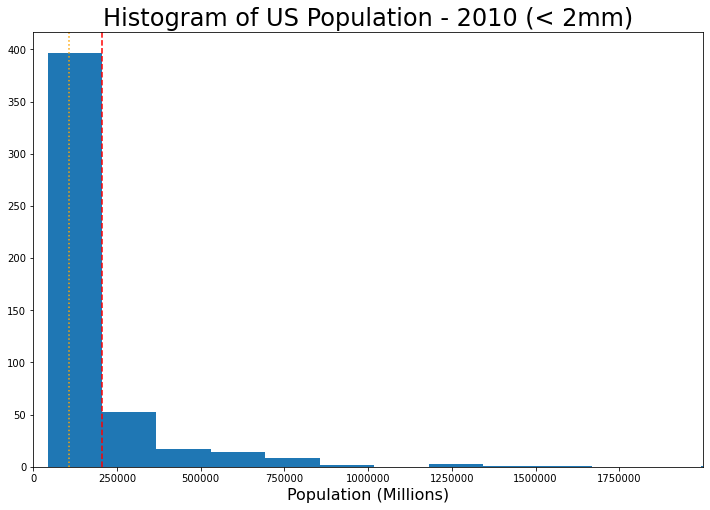

In [74]:
plt.figure(figsize = (12, 8))
plt.hist(us_pop['Population2010'], bins = 50)
plt.xlim(left = 0,right = 2_000_000)
plt.axvline(us_pop['Population2010'].mean(), color = 'red', linestyle = '--',)
plt.axvline(us_pop['Population2010'].median(), color = 'orange', linestyle = ':')
plt.title('Histogram of US Population - 2010 (< 2mm)', size = 24)
plt.xticks(ticks = [*range(0, 1_750_001, 250_000)],
          labels = [str(i) for i in range(0, 1_750_001, 250_000)])
plt.xlabel('Population (Millions)', size = 16);

In [75]:
# Which US Cities have populations larger than 1 Million
us_pop[us_pop['Population2010'] >= 1_000_000].sort_values(by = 'Population2010', ascending = False)

,StateAbbr,PlaceName,Population2010,Geolocation
342,NY,New York,8175133,"(40.69496068900, -73.9313850409)"
74,CA,Los Angeles,3792621,"(34.11822778980, -118.408500088)"
222,IL,Chicago,2695598,"(41.83729506150, -87.6862308732)"
429,TX,Houston,2099451,"(29.78066913960, -95.3860033966)"
388,PA,Philadelphia,1526006,"(40.00931478080, -75.1333888571)"
13,AZ,Phoenix,1445632,"(33.57241386950, -112.088995222)"
451,TX,San Antonio,1327407,"(29.47214753330, -98.5246763525)"
111,CA,San Diego,1307402,"(32.83556394180, -117.119792061)"
421,TX,Dallas,1197816,"(32.79398040660, -96.7656929463)"


In [76]:
# Which US Cities have populations larger than 0.5 Million
us_pop[us_pop['Population2010'] >= 500_000].sort_values(by = 'Population2010', ascending = False)

,StateAbbr,PlaceName,Population2010,Geolocation
342,NY,New York,8175133,"(40.69496068900, -73.9313850409)"
74,CA,Los Angeles,3792621,"(34.11822778980, -118.408500088)"
222,IL,Chicago,2695598,"(41.83729506150, -87.6862308732)"
429,TX,Houston,2099451,"(29.78066913960, -95.3860033966)"
388,PA,Philadelphia,1526006,"(40.00931478080, -75.1333888571)"
13,AZ,Phoenix,1445632,"(33.57241386950, -112.088995222)"
451,TX,San Antonio,1327407,"(29.47214753330, -98.5246763525)"
111,CA,San Diego,1307402,"(32.83556394180, -117.119792061)"
421,TX,Dallas,1197816,"(32.79398040660, -96.7656929463)"
213,HI,Honolulu,953207,"(21.45880393050, -157.973296737)"


In [77]:
# cleaning up latitude and longitude in us_pop dataframe.
us_pop.head()

,StateAbbr,PlaceName,Population2010,Geolocation
0,AL,Birmingham,212237,"(33.52756637730, -86.7988174678)"
1,AL,Hoover,81619,"(33.37676027290, -86.8051937568)"
2,AL,Huntsville,180105,"(34.69896926710, -86.6387042882)"
3,AL,Mobile,195111,"(30.67762486480, -88.1184482714)"
4,AL,Montgomery,205764,"(32.34726453330, -86.2677059552)"


In [78]:
len(us_pop)

500

In [79]:
us_pop['Geolocation'].str.split(pat = ',', expand = True)

,0,1
0,(33.52756637730,-86.7988174678)
1,(33.37676027290,-86.8051937568)
2,(34.69896926710,-86.6387042882)
3,(30.67762486480,-88.1184482714)
4,(32.34726453330,-86.2677059552)
...,...,...
495,(43.08098656940,-89.3915106344)
496,(43.06412589250,-87.9672412429)
497,(42.72745994940,-87.8134530240)
498,(43.00933322150,-88.2457679157)


In [80]:
us_pop = pd.merge(us_pop, us_pop['Geolocation'].str.split(pat = ',', expand = True), left_index = True, right_index = True)

# us_pop.replace({0: 'LATITUDE', 1: 'LONGITUDE'}, inplace = True)

us_pop = us_pop.iloc[:, :6].copy()

In [81]:
us_pop.columns = ['StateAbbr', 'PlaceName', 'Population2010', 'Geolocation', 'LATITUDE',
       'LONGITUDE']

us_pop.head()

,StateAbbr,PlaceName,Population2010,Geolocation,LATITUDE,LONGITUDE
0,AL,Birmingham,212237,"(33.52756637730, -86.7988174678)",(33.52756637730,-86.7988174678)
1,AL,Hoover,81619,"(33.37676027290, -86.8051937568)",(33.37676027290,-86.8051937568)
2,AL,Huntsville,180105,"(34.69896926710, -86.6387042882)",(34.69896926710,-86.6387042882)
3,AL,Mobile,195111,"(30.67762486480, -88.1184482714)",(30.67762486480,-88.1184482714)
4,AL,Montgomery,205764,"(32.34726453330, -86.2677059552)",(32.34726453330,-86.2677059552)


In [82]:
us_pop['LATITUDE'] = us_pop['LATITUDE'].apply(lambda x: x.replace('(', '')).astype(float)

us_pop.dtypes

StateAbbr          object
PlaceName          object
Population2010      int64
Geolocation        object
LATITUDE          float64
LONGITUDE          object
dtype: object

In [85]:
us_pop['LONGITUDE'] = us_pop['LONGITUDE'].apply(lambda x: x.replace(')', '')).astype(float)

In [86]:
us_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   StateAbbr       500 non-null    object 
 1   PlaceName       500 non-null    object 
 2   Population2010  500 non-null    int64  
 3   Geolocation     500 non-null    object 
 4   LATITUDE        500 non-null    float64
 5   LONGITUDE       500 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 23.6+ KB


## Experimenting with a map

In [89]:
with open('../data/gz_2010_us_040_00_500k.json') as file:
    base_map = json.load(file)

In [94]:
def get_mean_coords(lat, long):
    '''
    Returns a list of mean coordinates to create boundary on geojson file for Folium Map.
    
    =======
    ACCEPTS: 
    =======
    Two series corresponding to a location's coordinates. Values should be in floats.
    
    =======
    RETURNS
    =======
    A list of average latitude and longitude of series passed in. Provides boundary for map.
    
    ======
    RAISES
    ======
    ValueError if arguments are non-numeric
    ModuleNotImportedError if numpy not imported before running
    '''
    return [np.mean(lat), np.mean(long)]

In [96]:
get_mean_coords(us_pop['LATITUDE'], us_pop['LONGITUDE'])

[36.970324869967826, -97.98852811160499]

In [103]:
us_map = folium.Map(location=get_mean_coords(us_pop['LATITUDE'], us_pop['LONGITUDE']),
                      zoom_start = 4)

us_map

---

In [35]:
print(airports.head())

airports.info()

  IATA                              AIRPORT           CITY STATE COUNTRY  \
0  ABQ            Albuquerque International    Albuquerque    NM     USA   
1  ANC  Ted Stevens Anchorage International      Anchorage    AK     USA   
2  ATL    William B Hartsfield-Atlanta Intl        Atlanta    GA     USA   
3  AUS       Austin-Bergstrom International         Austin    TX     USA   
4  BDL                Bradley International  Windsor Locks    CT     USA   

    LATITUDE   LONGITUDE  
0  35.040222 -106.609194  
1  61.174320 -149.996186  
2  33.640444  -84.426944  
3  30.194533  -97.669872  
4  41.938874  -72.683228  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA       341 non-null    object 
 1   AIRPORT    341 non-null    object 
 2   CITY       337 non-null    object 
 3   STATE      337 non-null    object 
 4   COUNTRY    341 non-null    objec

Airports data frame looks to be in proper format.

---

In [9]:
print(f"Number of unique airports: {airports['IATA'].nunique()}")
airports['IATA'].unique()

Number of unique airports: 341


array(['ABQ', 'ANC', 'ATL', 'AUS', 'BDL', 'BHM', 'BNA', 'BOS', 'BUF',
       'BUR', 'BWI', 'CHS', 'CLE', 'CLT', 'CMH', 'CVG', 'DAL', 'DCA',
       'DEN', 'DFW', 'DTW', 'ELP', 'EWR', 'FLL', 'HNL', 'HOU', 'IAD',
       'IAH', 'IND', 'JAX', 'JFK', 'LAS', 'LAX', 'LGA', 'LIT', 'MCI',
       'MCO', 'MDW', 'MEM', 'MIA', 'MKE', 'MSP', 'MSY', 'OAK', 'OGG',
       'OKC', 'OMA', 'ONT', 'ORD', 'ORF', 'PBI', 'PDX', 'PHL', 'PHX',
       'PIT', 'PVD', 'RDU', 'RIC', 'RNO', 'RSW', 'SAN', 'SAT', 'SDF',
       'SEA', 'SFO', 'SJC', 'SJU', 'SLC', 'SMF', 'SNA', 'STL', 'TPA',
       'TUL', 'TUS', 'ABE', 'ABI', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV',
       'ACY', 'ADK', 'ADQ', 'AEX', 'AGS', 'AKN', 'ALB', 'ALO', 'AMA',
       'APN', 'ART', 'ASE', 'ATW', 'AVL', 'AVP', 'AZO', 'BET', 'BFL',
       'BGM', 'BGR', 'BIL', 'BIS', 'BJI', 'BLI', 'BMI', 'BOI', 'BPT',
       'BQK', 'BQN', 'BRD', 'BRO', 'BRW', 'BTM', 'BTR', 'BTV', 'BZN',
       'CAE', 'CAK', 'CDC', 'CDV', 'CEC', 'CHA', 'CHO', 'CIC', 'CID',
       'CIU', 'CLD',

In [10]:
# Checking output of method before store in df
# df['id'].str.split(pat = '\t', expand = True)

# Seeing what a merge looks like with this .str method
df = df.merge(df['id'].str.split(pat = '\t', expand = True), left_index = True, right_index = True)

df.rename(columns = {
    0: 'time_collected',
    1: 'station'
}, inplace = True)

df.head()

,date,id,obsv_time,automated,wind_speed,visibility,cloud_cover,temp_dewpt,altimeter,altimeter_remarks,ao2,time_collected,station,time_collected,station
0,2015-03-25,21:15:00\tKCXP,252115Z,AUTO,08005KT,10SM,CLR,17/M01,A3033,RMK,AO2,21:15:00,KCXP,21:15:00,KCXP
1,2015-03-25,21:13:00\tKWRB,252113Z,AUTO,06005KT,10SM,BKN014,OVC024,20/17,A3009,RMK,21:13:00,KWRB,21:13:00,KWRB
2,2015-03-25,21:12:00\tKTUL,252112Z,14006KT,10SM,TS,BKN035,BKN120,BKN250,24/16,A2975,21:12:00,KTUL,21:12:00,KTUL
3,2015-03-25,21:11:00\tKDRT,252111Z,AUTO,13007KT,10SM,SCT023,22/17,A2986,RMK,AO2,21:11:00,KDRT,21:11:00,KDRT
4,2015-03-25,21:10:00\tKBRL,252110Z,AUTO,33009KT,8SM,SCT016,07/03,A3006,RMK,AO2,21:10:00,KBRL,21:10:00,KBRL


In [12]:
new_col_order = ['date', 'time_collected', 'station', 'obsv_time', 'automated', 'wind_speed', 'visibility', 'cloud_cover',]

df = df.loc[:, new_col_order].copy()

df.head()

,date,time_collected,time_collected,station,station,obsv_time,automated,wind_speed,visibility,cloud_cover
0,2015-03-25,21:15:00,21:15:00,KCXP,KCXP,252115Z,AUTO,08005KT,10SM,CLR
1,2015-03-25,21:13:00,21:13:00,KWRB,KWRB,252113Z,AUTO,06005KT,10SM,BKN014
2,2015-03-25,21:12:00,21:12:00,KTUL,KTUL,252112Z,14006KT,10SM,TS,BKN035
3,2015-03-25,21:11:00,21:11:00,KDRT,KDRT,252111Z,AUTO,13007KT,10SM,SCT023
4,2015-03-25,21:10:00,21:10:00,KBRL,KBRL,252110Z,AUTO,33009KT,8SM,SCT016


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731241 entries, 0 to 7731240
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   date            object
 1   time_collected  object
 2   time_collected  object
 3   station         object
 4   station         object
 5   obsv_time       object
 6   automated       object
 7   wind_speed      object
 8   visibility      object
 9   cloud_cover     object
dtypes: object(10)
memory usage: 589.8+ MB


---

### Notes on columns:

* `Date` and `time_collected` could be combined and turned into a datetime datatype
* `station` should have the K stripped since most airport codes are in the 3 letters (although K will sometimes be at front)
* Can probably get rid of obsv_time, but will keep for now
* need to find a way to put wind_speed in easier/layman's representation
* Fairly confident `visibility` can be represented as a string
* Possible ordinal encoder from sklearn for `cloud_cover` or make simple ranking

There is an issue with the `automated` and `wind_speed` columns. Let's see the breakdown of observations that were automated recordings and which ones were not.

In [14]:
auto = 0
not_auto = 0

for i in df['automated']:
    if i == 'AUTO':
        auto += 1
    elif i != 'AUTO':
        not_auto += 1
    else:
        continue

print(f'Num. of Automated: {auto}')
print(f'Num. of Non-Automated: {not_auto}')
print(f'% Automated: {round(auto / len(df), 2)}')
print(f'% Non-Automated: {round(not_auto / len(df), 2)}')

Num. of Automated: 4361474
Num. of Non-Automated: 3369767
% Automated: 0.56
% Non-Automated: 0.44


---

## Data Manipulation

Too many observations in `df['automated']` to throw out observations that `!= 'AUTO'`

From here, `df` will be split into two separate dataframes based on the values in the `automated` column, selecting only the columns of interest to answer the problem, and then concatenated into a single dataframe.

Concatenation makes more sense than a merge because the columns will be the same in both dataframes and we aren't joining the data on a particular column or index.

In [15]:
df.head()

,date,time_collected,time_collected,station,station,obsv_time,automated,wind_speed,visibility,cloud_cover
0,2015-03-25,21:15:00,21:15:00,KCXP,KCXP,252115Z,AUTO,08005KT,10SM,CLR
1,2015-03-25,21:13:00,21:13:00,KWRB,KWRB,252113Z,AUTO,06005KT,10SM,BKN014
2,2015-03-25,21:12:00,21:12:00,KTUL,KTUL,252112Z,14006KT,10SM,TS,BKN035
3,2015-03-25,21:11:00,21:11:00,KDRT,KDRT,252111Z,AUTO,13007KT,10SM,SCT023
4,2015-03-25,21:10:00,21:10:00,KBRL,KBRL,252110Z,AUTO,33009KT,8SM,SCT016


In [16]:
df_auto = df[df['automated'] == 'AUTO'].copy()

print(f'Shape of df_auto: {df_auto.shape}')

df_auto.head()

Shape of df_auto: (4361474, 10)


,date,time_collected,time_collected,station,station,obsv_time,automated,wind_speed,visibility,cloud_cover
0,2015-03-25,21:15:00,21:15:00,KCXP,KCXP,252115Z,AUTO,08005KT,10SM,CLR
1,2015-03-25,21:13:00,21:13:00,KWRB,KWRB,252113Z,AUTO,06005KT,10SM,BKN014
3,2015-03-25,21:11:00,21:11:00,KDRT,KDRT,252111Z,AUTO,13007KT,10SM,SCT023
4,2015-03-25,21:10:00,21:10:00,KBRL,KBRL,252110Z,AUTO,33009KT,8SM,SCT016
5,2015-03-25,21:10:00,21:10:00,KCMX,KCMX,252110Z,AUTO,26016KT,4SM,-SN


In [21]:
# df_auto = df_auto[['date', 'id', 'wind_speed', 'visibility', 'cloud_cover']]

# df_auto.head()

In [22]:
df_non_auto = df[df['automated'] != 'AUTO'].copy()

df_non_auto.head()

,time,date,id,obsv_time,automated,wind_speed,visibility,cloud_cover,temp_dewpt,altimeter,altimeter_remarks,ao2
2,21:12:00,2015-03-25,KTUL,252112Z,14006KT,10SM,TS,BKN035,BKN120,BKN250,24/16,A2975
7,21:10:00,2015-03-25,KSZL,252110Z,03009KT,9SM,-RA,VCTS,SCT040,BKN100,10/07,A3000
9,21:09:00,2015-03-25,KGCK,252109Z,01029G38KT,10SM,BKN018,BKN033,BKN080,07/02,A3008,RMK
10,21:09:00,2015-03-25,KGSP,252109Z,02009KT,7SM,FEW011,SCT021,OVC041,16/13,A3015,RMK
15,21:07:00,2015-03-25,KSFO,252107Z,29014KT,10SM,FEW200,21/12,A3020,RMK,AO2,WSHFT


In [28]:
df_non_auto = df_non_auto[['date', 'id', 'automated', 'wind_speed', 'visibility']]

df_non_auto.head()

,date,id,automated,wind_speed,visibility
2,2015-03-25,KTUL,14006KT,10SM,TS
7,2015-03-25,KSZL,03009KT,9SM,-RA
9,2015-03-25,KGCK,01029G38KT,10SM,BKN018
10,2015-03-25,KGSP,02009KT,7SM,FEW011
15,2015-03-25,KSFO,29014KT,10SM,FEW200


In [29]:
print(df_auto.columns)

len(df_auto.columns)

Index(['date', 'id', 'wind_speed', 'visibility', 'cloud_cover'], dtype='object')


5

In [30]:
df_non_auto

,date,id,automated,wind_speed,visibility
2,2015-03-25,KTUL,14006KT,10SM,TS
7,2015-03-25,KSZL,03009KT,9SM,-RA
9,2015-03-25,KGCK,01029G38KT,10SM,BKN018
10,2015-03-25,KGSP,02009KT,7SM,FEW011
15,2015-03-25,KSFO,29014KT,10SM,FEW200
...,...,...,...,...,...
7731234,2016-04-28,KMFD,06006KT,10SM,OVC005
7731235,2016-04-28,KCRP,13013KT,7SM,SCT012
7731237,2016-04-28,KUES,07012G16KT,10SM,OVC008
7731238,2016-04-28,KVPS,20011KT,10SM,BKN012


In [31]:
df_non_auto.columns = df_auto.columns

df_non_auto.head()

,date,id,wind_speed,visibility,cloud_cover
2,2015-03-25,KTUL,14006KT,10SM,TS
7,2015-03-25,KSZL,03009KT,9SM,-RA
9,2015-03-25,KGCK,01029G38KT,10SM,BKN018
10,2015-03-25,KGSP,02009KT,7SM,FEW011
15,2015-03-25,KSFO,29014KT,10SM,FEW200


In [32]:
all_dfs = pd.concat([df_auto, df_non_auto])

In [33]:
all_dfs.head()

,date,id,wind_speed,visibility,cloud_cover
0,2015-03-25,KCXP,08005KT,10SM,CLR
1,2015-03-25,KWRB,06005KT,10SM,BKN014
3,2015-03-25,KDRT,13007KT,10SM,SCT023
4,2015-03-25,KBRL,33009KT,8SM,SCT016
5,2015-03-25,KCMX,26016KT,4SM,-SN


In [34]:
assert len(all_dfs) == len(df), "Not the same"

In [27]:
all_dfs.tail()

,date,id,wind_speed,visibility,cloud_cover
7731234,2016-04-28,KMFD,06006KT,10SM,OVC005
7731235,2016-04-28,KCRP,13013KT,7SM,SCT012
7731237,2016-04-28,KUES,07012G16KT,10SM,OVC008
7731238,2016-04-28,KVPS,20011KT,10SM,BKN012
7731240,2016-04-28,KMSN,07010KT,10SM,OVC016


In [28]:
all_dfs.id.value_counts(normalize = True)

KCOD    0.002448
KFKL    0.002447
KSGU    0.002445
KHYS    0.002445
KJHW    0.002444
          ...   
KRYY    0.000822
KISM    0.000800
KTIX    0.000734
KBVI    0.000556
KQQY    0.000540
Name: id, Length: 702, dtype: float64

In [29]:
all_dfs['id'].nunique()

702

Columns of interest are: 

- id
- wind_speed
- visibility
- cloud cover

Need to parse out KT for wind_speed, SM for visibility, and make conditions for cloud_cover

In [30]:
all_dfs['cloud_cover'].nunique()

13000

In [31]:
all_dfs.dtypes

date           object
id             object
wind_speed     object
visibility     object
cloud_cover    object
dtype: object

In [36]:
all_dfs['visibility'] = all_dfs['visibility'].str.strip('SM')
#all_dfs.drop(columns = ['visibiloity'], inplace = True)
all_dfs.head(20)

,date,id,wind_speed,visibility,cloud_cover
0,2015-03-25,KCXP,08005KT,10,CLR
1,2015-03-25,KWRB,06005KT,10,BKN014
3,2015-03-25,KDRT,13007KT,10,SCT023
4,2015-03-25,KBRL,33009KT,8,SCT016
5,2015-03-25,KCMX,26016KT,4,-SN
6,2015-03-25,KINL,29018G26KT,1,3/4SM
8,2015-03-25,KSKA,20011KT,9,OVC006
11,2015-03-25,KALI,16011KT,10,FEW020
12,2015-03-25,KDLF,17008KT,10,BKN026
13,2015-03-25,KFRI,03020G27KT,10,-RA


In [37]:
all_dfs['id'].str[1:].head()

0    CXP
1    WRB
3    DRT
4    BRL
5    CMX
Name: id, dtype: object

In [36]:
airport_codes = all_dfs['id'].unique()

print(len(airport_codes))

702


In [37]:
type(airport_codes)

numpy.ndarray

In [38]:
airport_codes = pd.DataFrame(airport_codes)

airport_codes.head()

,0
0,KCXP
1,KWRB
2,KDRT
3,KBRL
4,KCMX


In [42]:
all_dfs.head()

,date,id,wind_speed,visibility,cloud_cover
0,2015-03-25,KCXP,08005KT,10,CLR
1,2015-03-25,KWRB,06005KT,10,BKN014
3,2015-03-25,KDRT,13007KT,10,SCT023
4,2015-03-25,KBRL,33009KT,8,SCT016
5,2015-03-25,KCMX,26016KT,4,-SN


In [43]:
all_dfs.reset_index(inplace = True)

print(all_dfs.shape)

all_dfs.head()

del all_dfs['index']

print(all_dfs.shape)

all_dfs.head()

(7731241, 6)
(7731241, 5)


,date,id,wind_speed,visibility,cloud_cover
0,2015-03-25,KCXP,08005KT,10,CLR
1,2015-03-25,KWRB,06005KT,10,BKN014
2,2015-03-25,KDRT,13007KT,10,SCT023
3,2015-03-25,KBRL,33009KT,8,SCT016
4,2015-03-25,KCMX,26016KT,4,-SN


In [44]:
all_dfs.tail()

,date,id,wind_speed,visibility,cloud_cover
7731236,2016-04-28,KMFD,06006KT,10,OVC005
7731237,2016-04-28,KCRP,13013KT,7,SCT012
7731238,2016-04-28,KUES,07012G16KT,10,OVC008
7731239,2016-04-28,KVPS,20011KT,10,BKN012
7731240,2016-04-28,KMSN,07010KT,10,OVC016


### Wind_speed:

- first three digits are true direction in degrees
- next two digits are sustained speed
- if gusts are present, next two digits are max wind speed in past few minutes

Split 00KT from rest then drop? Then split 00 and KT and drop KT?

Regular expressions that would pull out relevant numbers

import re
^ check that out on pandas

In [45]:
all_dfs['wind_speed'].head()

0    08005KT
1    06005KT
2    13007KT
3    33009KT
4    26016KT
Name: wind_speed, dtype: object

In [46]:
all_dfs.dtypes

date           object
id             object
wind_speed     object
visibility     object
cloud_cover    object
dtype: object

---

Trying a single airport first. then seeing if can be iterated.
---

### KMFD

In [47]:
kmfd = all_dfs[all_dfs['id'] == 'KMFD']

kmfd.head()

,date,id,wind_speed,visibility,cloud_cover
2703,2015-03-26,KMFD,22006KT,9,CLR
3263,2015-03-26,KMFD,23004KT,8,CLR
3887,2015-03-26,KMFD,25005KT,7,CLR
4537,2015-03-26,KMFD,24004KT,6,BR
4741,2015-03-26,KMFD,32005KT,4,BR


In [48]:
len(kmfd)

10737

In [50]:
pd.to_datetime(kmfd['date'])

2703      2015-03-26
3263      2015-03-26
3887      2015-03-26
4537      2015-03-26
4741      2015-03-26
             ...    
7729826   2016-04-28
7729860   2016-04-28
7730670   2016-04-28
7731132   2016-04-28
7731236   2016-04-28
Name: date, Length: 10737, dtype: datetime64[ns]

In [51]:
kmfd['date'].unique()

array(['2015-03-26', '2015-03-27', '2015-03-28', '2015-03-29',
       '2015-03-30', '2015-03-31', '2015-04-01', '2015-04-02',
       '2015-04-03', '2015-04-04', '2015-04-05', '2015-04-07',
       '2015-04-08', '2015-04-09', '2015-04-11', '2015-04-13',
       '2015-04-14', '2015-04-15', '2015-04-16', '2015-04-19',
       '2015-04-20', '2015-04-21', '2015-04-22', '2015-04-23',
       '2015-04-26', '2015-04-27', '2015-04-28', '2015-04-29',
       '2015-04-30', '2015-05-01', '2015-05-02', '2015-05-04',
       '2015-05-05', '2015-05-06', '2015-05-07', '2015-05-08',
       '2015-05-10', '2015-05-11', '2015-05-12', '2015-05-13',
       '2015-05-15', '2015-05-16', '2015-05-17', '2015-05-18',
       '2015-05-19', '2015-05-20', '2015-05-21', '2015-05-22',
       '2015-05-23', '2015-05-24', '2015-05-25', '2015-05-26',
       '2015-05-27', '2015-05-28', '2015-05-29', '2015-05-30',
       '2015-05-31', '2015-06-02', '2015-06-03', '2015-06-04',
       '2015-06-05', '2015-06-08', '2015-06-09', '2015-

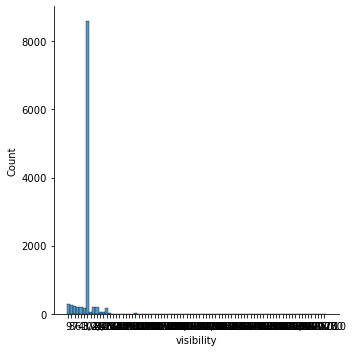

In [53]:
sns.displot(data = kmfd, x = 'visibility')

In [54]:
kmfd.visibility.value_counts()

10         8593
9           278
8           252
7           225
5           209
           ... 
28004KT       1
250V330       1
200V270       1
230V310       1
300V010       1
Name: visibility, Length: 81, dtype: int64

In [37]:
pct_clr = len(all_dfs[all_dfs['cloud_cover'] == 'CLR'])

print(pct_clr)

3246810


In [38]:
clr = round(
pct_clr / len(all_dfs), 4
)*100

print(f"Clear Skies: {clr}%")

Clear Skies: 42.0%


### Cloud_cover:

- CLEAR = sky clear
- FEW = 0-2 eighths
- SCT = scattered 3-4 eighths
- BKN = Broken - 5-7 eighths
- OVC = Overcast - 8 eighths

cloud cover, thinking rules based approach eg:

- clear = 5
- few = 4
- sct = 3
- bkn = 2
- else: 1



almost binary outcome

what proportions of days can you fly

then rank on proportion of flying days

In [54]:
all_dfs['id'].unique()

array(['KCXP', 'KWRB', 'KDRT', 'KBRL', 'KCMX', 'KINL', 'KSKA', 'KALI',
       'KDLF', 'KFRI', 'KHQM', 'KAFF', 'KDNL', 'KAST', 'KLBX', 'KTRM',
       'KDAN', 'KDAA', 'KADW', 'KBAB', 'KBAD', 'KBIF', 'KBIX', 'KCBM',
       'KCEF', 'KCOF', 'KDMA', 'KDYS', 'KFAF', 'KFBG', 'KFHU', 'KFSI',
       'KFTK', 'KGRF', 'KGRK', 'KGTB', 'KHMN', 'KHRT', 'KHST', 'KIAB',
       'KINS', 'KLFI', 'KLSF', 'KLSV', 'KLUF', 'KMCF', 'KMIB', 'KMUI',
       'KMXF', 'KOFF', 'KPAM', 'KPOB', 'KQGX', 'KRCA', 'KRDR', 'KRIV',
       'KRND', 'KSKF', 'KSSC', 'KSVN', 'KTCM', 'KTIK', 'KVAD', 'KWRI',
       'KHIB', 'KADF', 'KAND', 'KART', 'KBIH', 'KCEC', 'KCTB', 'KDIK',
       'KDUG', 'KEED', 'KEKO', 'KGFA', 'KINW', 'KJMS', 'KMTW', 'KOFK',
       'KQRH', 'KTPH', 'KUKI', 'KWJF', 'KWMC', 'KMMH', 'KOAJ', 'KONP',
       'KOUN', 'KPEQ', 'KPGV', 'KPNA', 'KPQI', 'KPVW', 'KQQY', 'KQSN',
       'KRKD', 'KRNH', 'KRUT', 'KSDY', 'KSEZ', 'KSGU', 'KSJS', 'KSME',
       'KSMN', 'KSOA', 'KTEX', 'KTVF', 'KVIS', 'KWWR', 'K36U', 'KASN',
      

In [57]:
print(round(len(all_dfs)/ uniques))

11013


11000 observations per station

___